In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
#DATASET_PATH = 'drive/MyDrive/ml-data/ocr-dataset/words-dataset-100k.npz'
DATASET_PATH = 'drive/MyDrive/ml-data/ocr-dataset/words-dataset-200k-6char.npz'

CLASS_NAMES = '-АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯ'

N_CLASSES = 32
OUTPUT_MAX_CHARS = 13

assert len(CLASS_NAMES) == N_CLASSES

In [ ]:
with np.load(DATASET_PATH) as npz:
    data = npz['data']
    labels = npz['labels']
    
data.shape, labels.shape

((200000, 16, 160), (200000,))

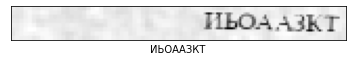

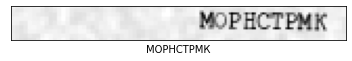

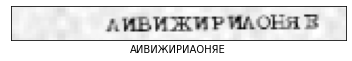

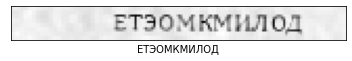

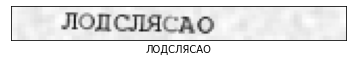

In [ ]:
for i in range(5):
    plt.imshow(255 - data[-1 - i], cmap='gray', vmax=255, vmin=0)
    plt.xlabel(labels[-1 - i])
    plt.xticks([]), plt.yticks([])
    plt.show()

## Preprocessing

### Filtering

In [ ]:
REMOVE_LABELS_SHORTER_OR_EQUAL = 5
if REMOVE_LABELS_SHORTER_OR_EQUAL:
    lens = np.array([len(label) for label in labels])
    drop_ids = lens <= REMOVE_LABELS_SHORTER_OR_EQUAL
    data = data[~drop_ids]
    labels = labels[~drop_ids]
    print(f'Dropped {sum(drop_ids)} ({drop_ids.mean():.2%}), '
          f'left {len(data)} ({1 - drop_ids.mean():.2%})')
    

LIMIT_DATA = None
if LIMIT_DATA:
    data = data[:LIMIT_DATA]
    labels = labels[:LIMIT_DATA]

Dropped 0 (0.00%), left 200000 (100.00%)


### Input

In [ ]:
input_data = data[..., None].astype(np.float32) / 255

### Labels

In [ ]:
## Label conversion tables
# char -> integer id
class_ids = pd.Series(
    range(N_CLASSES),
    index=list(CLASS_NAMES))

# char -> one-hot vector
class_one_hot = pd.Series(
    list(np.identity(N_CLASSES, dtype=np.uint8)),
    index=list(CLASS_NAMES))

# integer id -> char
ids_class = np.array(list(CLASS_NAMES))

class_one_hot[:3]

-    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
А    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Б    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

In [ ]:
#@title { form-width: "1px" }
#@markdown ```python
#@markdown class LabelEncoder()
#@markdown ```
class LabelEncoder:
    def __init__(self):
        self.class_ids = pd.Series(range(N_CLASSES),
                                   index=list(CLASS_NAMES))
        
    def encode(self, text_labels):
        """
        Batch of text labels to k-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES*OUTPUT_MAX_CHARS))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES * OUTPUT_MAX_CHARS), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            chars = list(text_label.ljust(OUTPUT_MAX_CHARS, '-'))
            batch[i] = np.concatenate(class_one_hot[chars])
        return batch
    
    
    def encode_nth_last_char(self, text_labels, n=1):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            batch[i] = class_one_hot[text_label[-n]]
        return batch


    def encode_nth_char(self, text_labels, n):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            char = text_label[n] if n < len(text_label) else '-'
            batch[i] = class_one_hot[char]
        return batch

    
    def encode_first_char(self, text_labels):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            batch[i] = class_one_hot[text_label[0]]
        return batch


    def encode_text_len(self, text_labels):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        # 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 (10 classes), min=4, max=13
        batch = np.empty((batch_size,), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
            batch[i] = len(text_label) - 4  # min=0, max=9
        return batch

    
    def decode(self, k_hot_labels):
        """ Batch of k-hot labels (2d) to array of strings (1d). """
        words = np.reshape(k_hot_labels, (-1, OUTPUT_MAX_CHARS, N_CLASSES)).argmax(axis=-1)
        labels = []
        for ids in words:
            chars = ids_class[ids]
            word = ''.join(chars).strip('-')
            labels.append(word)
        return np.array(labels)


    def decode_one_hot(self, one_hot_labels):
        """ Batch of 1-hot labels (2d) to array of chars (1d). """
        char_ids = np.argmax(one_hot_labels, axis=-1)
        return ids_class[char_ids]


    def decode_text_len(self, one_hot_labels):
        """ Batch of 1-hot labels (2d) to array of chars (1d). """
        raise NotImplementedError


label_encoder = LabelEncoder()

# Tests
test_out = label_encoder.encode(['ФЫВГ', 'ДЛЕЯА'])
assert test_out.shape == (2, 13 * 32)
assert test_out.sum() == 13 * 2

In [ ]:
labels_one_hot = label_encoder.encode_nth_last_char(labels, n=5)

## Train test split

In [ ]:
def print_train_test_info(train, test, prefix=''):
    template = '{}: {}, {}, min={:.3f}, max={:.3f}, avg={:.3f}, std={:.3f}'
    print(template.format(prefix + 'train', train.shape, train.dtype,
        train.min(), train.max(), train.mean(), train.std()))
    print(template.format(prefix + 'test ', test.shape, test.dtype,
        test.min(), test.max(), test.mean(), test.std()))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input_data, labels_one_hot, test_size=0.3)
print_train_test_info(x_train, x_test, 'x_')
print_train_test_info(y_train, y_test, 'y_')

x_train: (140000, 16, 160, 1), float32, min=0.000, max=1.000, avg=0.142, std=0.191
x_test : (60000, 16, 160, 1), float32, min=0.000, max=1.000, avg=0.142, std=0.191
y_train: (140000, 32), uint8, min=0.000, max=1.000, avg=0.031, std=0.174
y_test : (60000, 32), uint8, min=0.000, max=1.000, avg=0.031, std=0.174


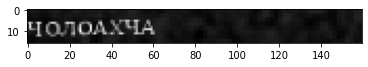

In [ ]:
plt.imshow(x_train[7, ..., 0], cmap='gray', vmin=0, vmax=1)

In [ ]:
CLASS_NAMES[y_train[7].argmax()]

'О'

## Model design

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='val')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc='upper left')

In [ ]:
import tensorflow.keras.layers as KL

conv_params = dict(kernel_initializer='he_normal')

In [ ]:
#@title { form-width: "1px" }
#@markdown ```python
#@markdown model_lg
#@markdown ```
#@markdown (larger version, not used)
if 0:
    model_lg = tf.keras.Sequential([
        KL.InputLayer(input_shape=(16, 160, 1)),
        KL.Conv2D(64, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)),  # [None, 8, 80, 64]

        KL.Conv2D(128, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)),  # [None, 4, 40, 128]

        KL.Conv2D(256, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.Conv2D(256, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)), # [None, 4, 20, 256]

        KL.Conv2D(512, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.Conv2D(512, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)),  # [None, 4, 10, 512]

        KL.Conv2D(512, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),

        KL.Flatten(),  # 5120
        KL.Dense(512, activation='relu'),
        KL.Dense(256, activation='relu'),
        KL.Dense(32, activation='softmax'),
    ])

    print(f'Model size: {model_lg.count_params() * 4 / 10**6:.1f}MB')

    model_lg(np.empty((64, 16, 160, 1), dtype=np.float32)).shape

In [ ]:
from locale import CHAR_MAX
#@title { form-width: "1px" }
#@markdown ```python
#@markdown model
#@markdown ```
model = tf.keras.Sequential([
    KL.InputLayer(input_shape=(16, 160, 1)),
    KL.Conv2D(32, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)),  # [None, 8, 80, 32]

    KL.Conv2D(64, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)),  # [None, 4, 40, 64]

    KL.Conv2D(128, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)), # [None, 4, 20, 128]

    KL.Conv2D(256, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.Conv2D(256, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)),  # [None, 4, 10, 256]

    KL.Flatten(),  # 2560
    KL.Dense(256, activation='relu'),
    KL.Dense(N_CLASSES, activation='softmax'),
])

print(f'Model size: {model.count_params() * 4 / 10**6:.1f}MB')

model(np.empty((64, 16, 160, 1), dtype=np.float32)).shape

Model size: 6.6MB


TensorShape([64, 32])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'
)

In [ ]:
test_out = model(x_train[:64])
print(test_out.shape, test_out[0][:5])

(64, 32) tf.Tensor([0.00931844 0.0332588  0.03384236 0.03990422 0.01769493], shape=(5,), dtype=float32)


## Training

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
2188/2188 [==============================] - 33s 15ms/step - loss: 1.0874 - accuracy: 0.6775 - val_loss: 0.6947 - val_accuracy: 0.7947
Epoch 2/5
2188/2188 [==============================] - 33s 15ms/step - loss: 0.5021 - accuracy: 0.8494 - val_loss: 0.5484 - val_accuracy: 0.8392
Epoch 3/5
2188/2188 [==============================] - 32s 15ms/step - loss: 0.3076 - accuracy: 0.9052 - val_loss: 0.3686 - val_accuracy: 0.8930
Epoch 4/5
2188/2188 [==============================] - 33s 15ms/step - loss: 0.2180 - accuracy: 0.9316 - val_loss: 0.3227 - val_accuracy: 0.9074
Epoch 5/5
2188/2188 [==============================] - 32s 15ms/step - loss: 0.1608 - accuracy: 0.9488 - val_loss: 0.2481 - val_accuracy: 0.9312


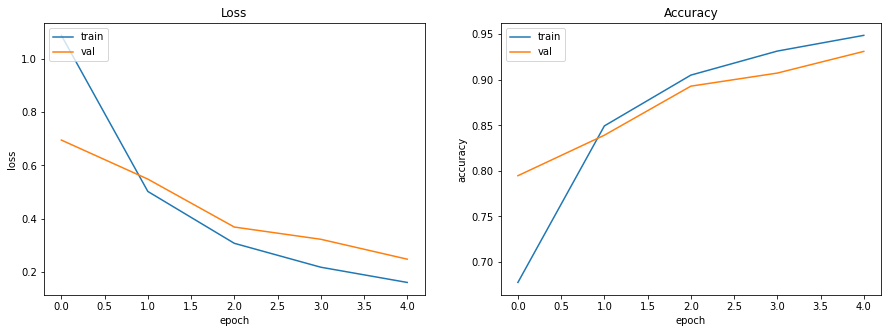

In [ ]:
plot_history(history)

## Save

In [ ]:
model.save('model_char-5')

In [ ]:
!zip -r model_char-5 model_char-5

  adding: model_char-5/ (stored 0%)
  adding: model_char-5/keras_metadata.pb (deflated 94%)
  adding: model_char-5/variables/ (stored 0%)
  adding: model_char-5/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: model_char-5/variables/variables.index (deflated 73%)
  adding: model_char-5/assets/ (stored 0%)
  adding: model_char-5/saved_model.pb (deflated 90%)


In [ ]:
!cp model_char-5.zip drive/MyDrive/ml-data/ocr-dataset/

In [ ]:
!ls -lah drive/MyDrive/ml-data/ocr-dataset/

total 474M
drwx------ 2 root root 4.0K Dec  3 10:06 .ipynb_checkpoints
-rw------- 1 root root  14M Dec  3 15:28 model_char0.zip
-rw------- 1 root root  14M Dec  3 22:35 model_char-1.zip
-rw------- 1 root root  14M Dec  3 15:47 model_char1.zip
-rw------- 1 root root  14M Dec  3 15:56 model_char2.zip
-rw------- 1 root root  14M Dec  3 22:50 model_char-3.zip
-rw------- 1 root root  14M Dec  3 16:41 model_char3.zip
-rw------- 1 root root  14M Dec  3 16:57 model_char4.zip
-rw------- 1 root root  16M Dec  3 23:13 model_char-5.zip
-rw------- 1 root root  13M Dec  3 21:48 model_char5.zip
-rw------- 1 root root  14M Dec  3 22:06 model_char6.zip
-rw------- 1 root root  15M Dec  3 18:58 model_text_len.zip
-rw------- 1 root root 103M Dec  3 10:49 words-dataset-100k.npz
-rw------- 1 root root 224M Dec  3 21:43 words-dataset-200k-6char.npz


## Load and verify

In [ ]:
model_loaded = tf.keras.models.load_model('model_char-5')
out = model_loaded(x_test[-10:])
list(label_encoder.decode_one_hot(out))[::-1]

['У', 'О', 'Ж', 'О', 'И', 'П', 'Н', 'К', 'О', 'Н']

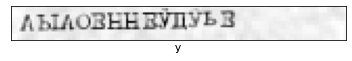

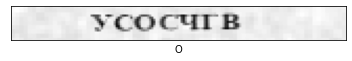

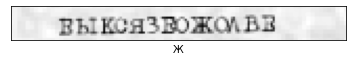

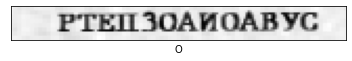

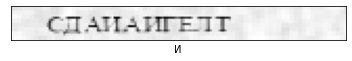

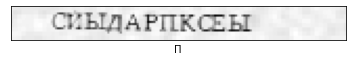

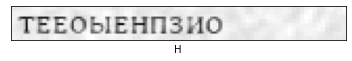

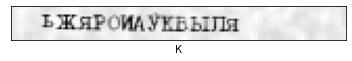

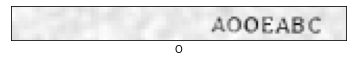

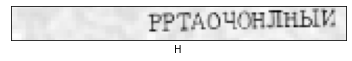

In [ ]:
for i in range(10):
    plt.imshow(1 - x_test[-1 - i, ..., 0], cmap='gray', vmin=0, vmax=1)
    plt.xlabel(label_encoder.decode_one_hot(y_test[-1 - i]))
    plt.xticks([]), plt.yticks([])
    plt.show()